<a href="https://colab.research.google.com/github/AlexTako/AI_practice/blob/main/AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

С помощью AutoKeras нашел оптимальную модель для решения следующей задачи:

Использовал [русский корпус новостей от Lenta.ru](https://www.kaggle.com/datasets/yutkin/corpus-of-russian-news-articles-from-lenta/data) подобрал и обучил модель классифицировать новости по заголовкам на классы (поле topic в датасете). Использовал 9 самых часто встречаемых топиков и 10-й для остальных, не вошедших в 9 классов. Оценил модель с помощью отчета о классификации.


# Описание данных

Найти адекватный датасет по обращениям на задачу по классификации довольно трудное занятие, поэтому взял другой

[World News Category](https://https://www.kaggle.com/datasets/khoshbayani/news-texts)

Данный датасет содержит в себе новости с 4 января 2018 года по 31 марта 2024 года по трем категориям.
Категории: Политика, Технологии, Наука

In [ ]:
# Пробуем загрузить библиотеки
!pip install autokeras==1.1.0 tensorflow==2.15.1 keras-nlp==0.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.1/527.1 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 96.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 103.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.

In [ ]:
# Проверяем версии
import tensorflow as tf
tf.__version__

'2.15.1'

In [ ]:
import keras_nlp as nlp
nlp.__version__

'0.5.1'

In [ ]:
# Библиотека матричного вычисления
import numpy as np
# Библиотека для работы с данными
import pandas as pd
# Библиотека для работы с регулярными выражениями
import re
# Библиотека для работы с фреймворком TensorFlow
import tensorflow as tf
# Библиотека AutoML autokeras
import autokeras as ak
# Библиотеки для построения графиков и их стилизации
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Утилита для расщепления выборки
from sklearn.model_selection import train_test_split

# Необходимые метрики для построения Матрицы ошибок и отчета о классификации
from sklearn.metrics import classification_report, confusion_matrix

# encoder для столбца label
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = pd.read_csv('/content/news.csv')
df['text'] = df['text'].astype(str)

df.head()

,date,text,label
0,2018-01-04T15:35:56,Farmers will get subsidies for turning fields ...,politic
1,2018-01-04T15:35:57,Vanuatu bans non-biodegradable plastic to prot...,politic
2,2018-01-04T17:00:49,Ex-British PM Tony Blair ups calls for Labour ...,politic
3,2018-01-04T17:00:50,UK's Tony Blair argues voters deserve another ...,politic
4,2018-01-04T18:01:34,Germany had so much renewable energy over Chri...,politic


In [ ]:
# Удаляем колонку даты
df = df.drop('date', axis = 1)
# Удаляем строки без значений
df.head()

,text,label
0,Farmers will get subsidies for turning fields ...,politic
1,Vanuatu bans non-biodegradable plastic to prot...,politic
2,Ex-British PM Tony Blair ups calls for Labour ...,politic
3,UK's Tony Blair argues voters deserve another ...,politic
4,Germany had so much renewable energy over Chri...,politic


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
df["label_code"] = ord_enc.fit_transform(df[["label"]]).astype(int)
print(df)

                                                     text       label  \
0       Farmers will get subsidies for turning fields ...     politic   
1       Vanuatu bans non-biodegradable plastic to prot...     politic   
2       Ex-British PM Tony Blair ups calls for Labour ...     politic   
3       UK's Tony Blair argues voters deserve another ...     politic   
4       Germany had so much renewable energy over Chri...     politic   
...                                                   ...         ...   
127388  Wind generates record annual percentage of UK ...  technology   
127389  HP ends ties with Russia, shutting down its Ru...  technology   
127390  AT&T confirms data for 73 million customers le...  technology   
127391  Missouri AG sues Media Matters as Republicans ...  technology   
127392  Breakdown of Safety Is Not Unique to Boeing — ...  technology   

        label_code  
0                0  
1                0  
2                0  
3                0  
4                0

In [ ]:
# Кодирование label по one hot encoder
# encoder = OneHotEncoder(handle_unknown='ignore')
# encoder_df = pd.DataFrame(encoder.fit_transform(df[['label']]).toarray())
# encoded_df = df.join(encoder_df)
# encoded_df.drop('label', axis= 1 , inplace= True )
# encoded_df['label'] = (encoded_df[0].astype(int)).astype(str) + (encoded_df[1].astype(int)).astype(str) + (encoded_df[2].astype(int)).astype(str)
# encoded_df.rename(columns = {0:'politic', 1:'technology', 2:'science'}, inplace = True )
# encoded_df.head()

,text,label,politic,technology,science
0,Farmers will get subsidies for turning fields ...,politic,1.0,0.0,0.0
1,Vanuatu bans non-biodegradable plastic to prot...,politic,1.0,0.0,0.0
2,Ex-British PM Tony Blair ups calls for Labour ...,politic,1.0,0.0,0.0
3,UK's Tony Blair argues voters deserve another ...,politic,1.0,0.0,0.0
4,Germany had so much renewable energy over Chri...,politic,1.0,0.0,0.0


In [ ]:
print('Найдено дубликатов: ', df.duplicated().sum())

# Удаляем дубликаты
df.drop_duplicates(subset=['text'], inplace = True)

print('Осталось дубликатов после очистки: ', df.duplicated().sum())

Найдено дубликатов:  1970
Осталось дубликатов после очистки:  0


In [ ]:
X_train, X_tmp, y_train, y_tmp = train_test_split(np.array(df.text),
                                                  np.array(df.label_code),
                                                  test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_tmp,
                                                  y_tmp,
                                                  test_size=0.5)

In [ ]:
print('Форма входных данных: ', X_train.shape)
print('Форма выходных меток: ', y_train.shape)
print('Пример заголовка статьи: ', X_train[0])
print('Пример категории: ', y_train[0])

Форма входных данных:  (87174,)
Форма выходных меток:  (87174,)
Пример заголовка статьи:  BP has pledged to align its business more closely with global climate goals and link the bonuses of 36,000 employees to greenhouse gas reduction targets.
Пример категории:  2


In [ ]:
# Для экономии ОЗУ удаляем уже ненужные данные, после чего python запускает сборщик "мусора" для очистки памяти
del df, X_tmp, y_tmp

In [ ]:
# Создание ансамбля моделей (3 наиболее подходящие к данным моделей)
clf = ak.TextClassifier(overwrite=True, max_trials=2, objective='val_accuracy')

# Обучаем 2 модели на 4-х эпохах, размер пакета подбирается автоматически
result_training = clf.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val))

Trial 2 Complete [00h 03m 36s]
val_accuracy: 0.8537473082542419

Best val_accuracy So Far: 0.8537473082542419
Total elapsed time: 00h 06m 37s
Epoch 1/4
2725/2725 [==============================] - 90s 31ms/step - loss: 0.7571 - accuracy: 0.6659 - val_loss: 0.4981 - val_accuracy: 0.8146
Epoch 2/4
2725/2725 [==============================] - 60s 22ms/step - loss: 0.4647 - accuracy: 0.8242 - val_loss: 0.4350 - val_accuracy: 0.8482
Epoch 3/4
2725/2725 [==============================] - 61s 22ms/step - loss: 0.3907 - accuracy: 0.8521 - val_loss: 0.4248 - val_accuracy: 0.8516
Epoch 4/4
2725/2725 [==============================] - 61s 22ms/step - loss: 0.3624 - accuracy: 0.8617 - val_loss: 0.4117 - val_accuracy: 0.8511


In [ ]:
# Последовательно экспортируем лучшую модель и по ней выводим отчет
clf.export_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 expand_last_dim (ExpandLas  (None, 1)                    0         ['input_1[0][0]']             
 tDim)                                                                                            
                                                                                                  
 text_vectorization (TextVe  (None, 512)                  0         ['expand_last_dim[0][0]']     
 ctorization)                                                                                     
                                                                                              

In [ ]:
# Предсказание на лучшей модели
predicted_y = clf.predict(X_test)

# Оценка лучшей модели на тестовых данных
print(clf.evaluate(X_test, y_test))

584/584 [==============================] - 6s 10ms/step - loss: 0.4046 - accuracy: 0.8572
[0.40459123253822327, 0.8572345972061157]


In [ ]:
def plot_graphs(history, key):
    # Используем библиотеку seaborn для задания стиля и цветовой схемы графика
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')

    # Задаем размер полотна для рисования графика
    plt.figure(figsize=(12,6))

    # Отображаем график выбранного параметра
    plt.plot(history.history[key],   # данные для построения графика
             marker='o',             # использовать маркер для точек на графике
             color=palette[2],       # использовать цвет третий в палитре (нумерация с 0)
             linewidth=2.5,          # ширина линии
             label=key)              # подпись легенды

    # График для проверочной выборки
    if 'val_'+key in history.history:
        plt.plot(history.history['val_'+key], # данные для построения графика
                 marker='o',                  # использовать маркер для точек на графике
                 color=palette[4],            # использовать цвет пятый в палитре
                 linewidth=2.5,               # ширина линии
                 label='val_'+key)            # подпись легенды

    # подпись оси Х, размер шрифта - 12
    plt.xlabel("Эпоха", fontsize=12)
    # подпись оси Y, размер шрифта - 12
    plt.ylabel(key, fontsize=12)

    # подпись заголовка графика, размер шрифта - 14
    plt.title('Обучающая и проверочная выборки ('+key.title()+')', fontsize=14)

    # отображение легенды, размер шрифта - 12
    plt.legend(fontsize=12)

    # задаем сетку на графике
    plt.grid(True)

    # отрисовываем полотно со всеми графиками
    plt.show()


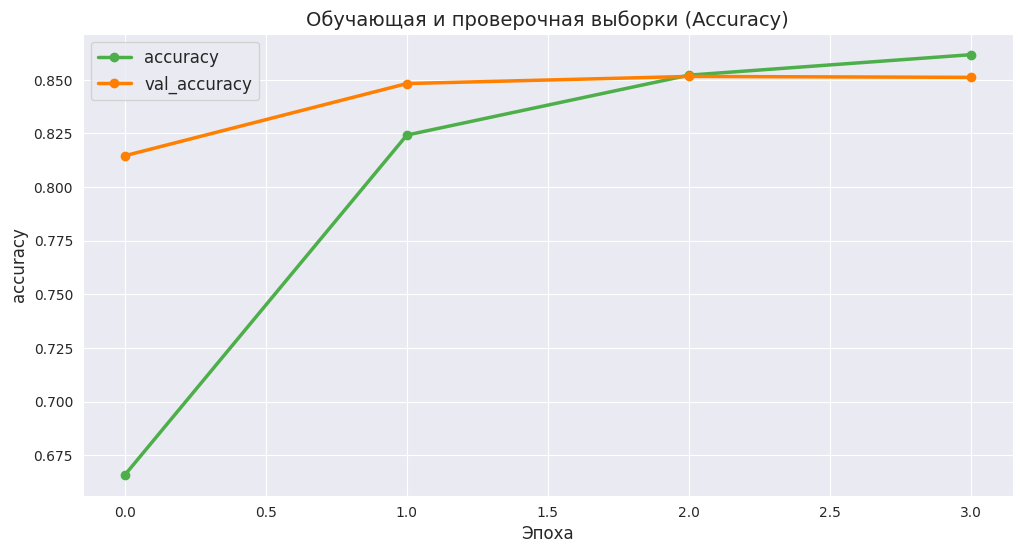

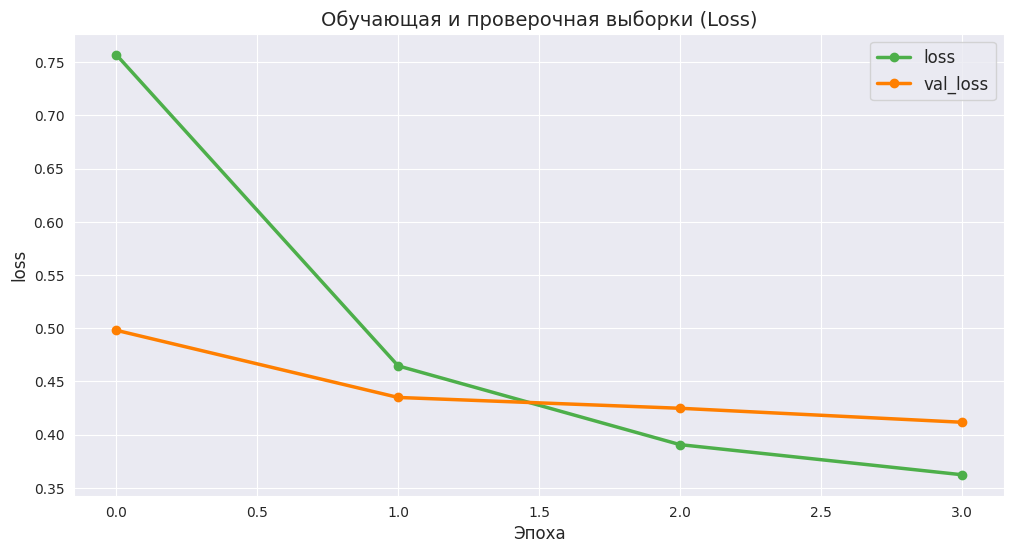

In [ ]:
# строим график точности
plot_graphs(result_training, "accuracy")

# строим график потерь
plot_graphs(result_training, "loss")

In [ ]:
# Входной слой обработки текста (векторизация)
input_node = ak.TextInput()
# Здесь идет подбор слоев для работы с текстом
output_node = ak.TextBlock()(input_node)
# Выходной слой должен обеспечивать классификацию
output_node = ak.ClassificationHead()(output_node)
# Собираем модель, аналогично как мы это делали для Keras functional API, используем 2 модели (max_trials=2)
clf_2 = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True,  max_trials=2, objective='val_accuracy'
)
# Обучаем 2 пободранных модели на 3 эпохах
res_2 = clf_2.fit(X_train, y_train, epochs=3)

Trial 2 Complete [00h 01m 19s]
val_accuracy: 0.8433444499969482

Best val_accuracy So Far: 0.8435741066932678
Total elapsed time: 00h 02m 39s
Epoch 1/3
2725/2725 [==============================] - 38s 13ms/step - loss: 0.4976 - accuracy: 0.8007
Epoch 2/3
2725/2725 [==============================] - 20s 7ms/step - loss: 0.3636 - accuracy: 0.8651
Epoch 3/3
2725/2725 [==============================] - 21s 8ms/step - loss: 0.3224 - accuracy: 0.8804


In [ ]:
clf_2.export_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLas  (None, 1)                 0         
 tDim)                                                           
                                                                 
 text_vectorization (TextVe  (None, 64)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 64, 128)           640128    
                                                                 
 dropout (Dropout)           (None, 64, 128)           0         
                                                                 
 conv1d (Conv1D)             (None, 62, 32)            12320 

In [ ]:
!pip install keras-tuner
!pip install tensorflow

In [ ]:
# Библиотека для работы с фреймворком TensorFlow
import tensorflow as tf

# Импортируем фреймворк Keras
import keras

# Для работы с слоями
from keras import layers

# Тюнеры для KerasTuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Для быстрой векторизации слов
from tensorflow.keras.preprocessing.text import one_hot

# Выравнивание последовательностей по длиине
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Задаем размер словаря
vocab_size = 10000

# Выравниваем входные последовательности до заданной длины
sentence_len = 25

# Функция предобработки данных
def data_preparation(data):
    corpus=[]

    for text in data:
        # убираем из текстов все, что не является буквами
        text=re.sub("[^a-zA-Z]", " ", text)
        # Убираем все заглавные буквы
        text=text.lower()
        # Избавляемся от лишних пробелов
        text=text.split()
        text=" ".join(text)
        corpus.append(text)

    # Векторизуем текст
    oneHot_doc=[one_hot(input_text=words, n=vocab_size)
               for words in corpus
               ]
    # обрезаем или забиваем нулями до заданной длины входные последовательности
    embedded_doc=pad_sequences(sequences=oneHot_doc,
                              maxlen=sentence_len,
                              padding="post")
    return embedded_doc

In [ ]:
# Запускаем предобработку данных
train_data = data_preparation(X_train)
test_data = data_preparation(X_test)

In [ ]:
# Вывод первого заголовка обучающей выборки в исходном виде
X_train[0]

'BP has pledged to align its business more closely with global climate goals and link the bonuses of 36,000 employees to greenhouse gas reduction targets.'

In [ ]:
# Вывод первого заголовка обучающей выборки в векторизованном виде
train_data[0]

array([ 204,  531, 1994, 5325, 8405, 1768, 1928, 5715,  182, 8035, 2558,
       1543, 8187, 7317, 1209, 5269, 6159, 3696, 3972, 5325, 5889,  506,
       8462, 7545,    0], dtype=int32)

In [ ]:
# Определение функции для построения модели
def build_model(hp):
    model = keras.Sequential()
    # Добавление слоев эмбеддинга
    model.add(layers.Embedding(input_dim=vocab_size,
      output_dim=hp.Int('embedding_dim', min_value=8, max_value=32, step=8) # задаем диапазон изменения параметра embedding_dim
    ))
    model.add(layers.GlobalAveragePooling1D())

    # Задаем количество слоев, их размерности и функции активации
    for i in range(hp.Int('num_layers', 1, 4)): # число слоев
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 32, 256, 32), # размерность
                               activation=hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid']))) # подбор функции активации
    model.add(layers.Dense(1, activation='sigmoid')) # Выходной слой

    # Определение оптимизатора и скомпилирование модели
    # learning_rate - выбирается из списка [1e-3, 1e-4, 1e-5]
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', )),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model